# Reference level cross validation
In scenarios where you have no prior knowledge of the elevation of the density contrast of interest, we use a flat starting model with an arbitrary reference level. The reference level (`zref`) is very important to the inversion as different values can vertically shift the inverted topography. Here we present a cross-validation approach to determine the optimal value for `zref`. This follows the same approach as the past notebook (`density_cross_validation.ipynb`). To simplify, we assume we know the appropiate density constrast value to use. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import cross_validation, inversion, plotting, synthetic, utils

## Create observed gravity data

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Constraint points

Sample the starting topography at 10 random locations to create a set of constraints points, simulating locations where the topography is known.

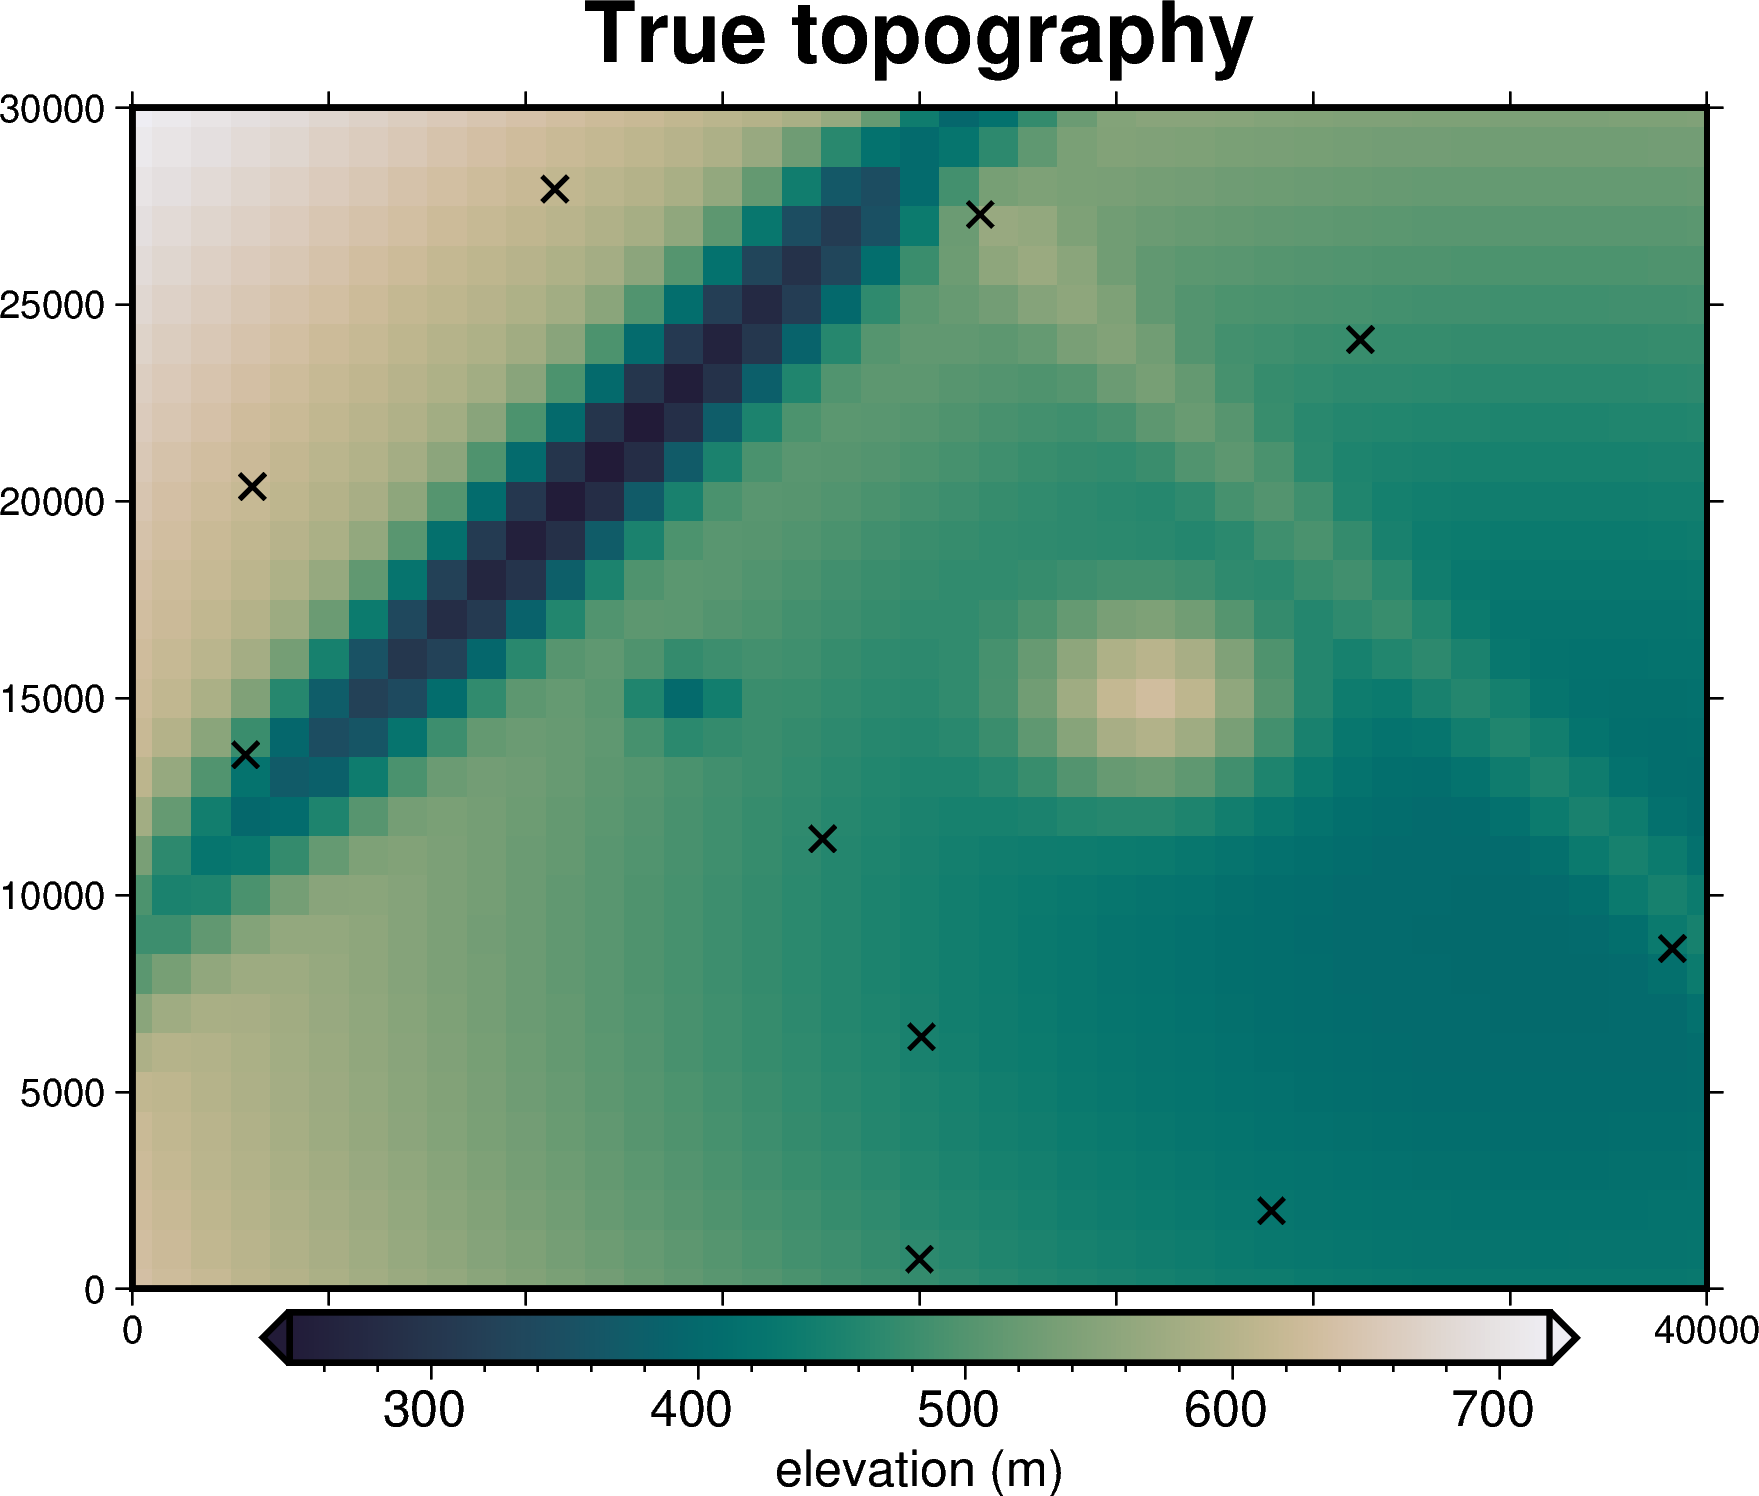

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    fig_height=10,
    title="True topography",
    cmap="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)
fig.show()

### True topography prism layer

In [4]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    true_topography >= true_zref, true_density_contrast, -true_density_contrast
)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    true_zref,
    density=density_grid,
)

mean of true topography: 492.2704164812973 m 


### Forward gravity of prism layer

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


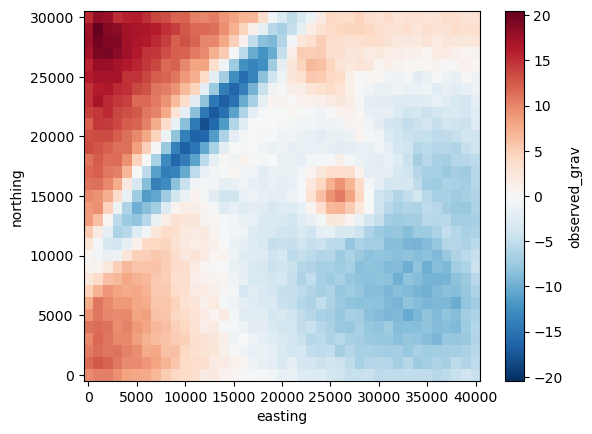

In [6]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

For simplicity here we assume that we know the optimal density contrast value and use this when creating our starting model.

What we don't know in this scenario is what reference elevation `zref` to use. We will use a cross-validation of a range of elevations to find the one which is optimal.

Each `zref` will give a cross validation score, and the lowest score will show which `zref` is optimal. 

The cross validation score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points, same as in the past nootebook. 

## Get Cross Validation Score

First we need to use the `zref` value to create the starting model. We will then use this in an inversion to calculate a `score`.

In [7]:
# set a zref value
zref = 300  # instead of the correct value of ~490 m

# assume we know the optimal density contrast value
density_contrast = true_density_contrast

# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

# gravity of starting model is 0 since its flat, so observed_grav = misfit
grav_df["misfit"] = grav_df["observed_grav"]
grav_df["reg"] = 0
grav_df["res"] = grav_df.misfit

# set kwargs to pass to the inversion
kwargs = {
    "grav_data_column": "observed_grav",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    "solver_damping": 0.1,
    "zref": zref,
    "density_contrast": density_contrast,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# run inversion, calculate the score
score = cross_validation.constraints_cv_score(
    grav_df=grav_df,
    constraints_df=constraint_points,
    **kwargs,
)
print(f"CV score: {score}")

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

CV score: 194.80803233461748


## Cross Validation
Lets see if we can improve the score with other values for `zref`. 

Now we can repeat this with a range of `zref` values to find the optimal (lowest) score. But remember we need to recreate the starting model with each `zref`.

Zref/Density pairs:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

INFO:root:Reference level: 400.0, Density contrast: 2669 -> Score: 95.28058460015494
INFO:root:Reference level: 428.57142857142856, Density contrast: 2669 -> Score: 66.79420158753959
INFO:root:Reference level: 457.14285714285717, Density contrast: 2669 -> Score: 38.39424789322195
INFO:root:Reference level: 485.7142857142857, Density contrast: 2669 -> Score: 10.84043086654026
INFO:root:Reference level: 514.2857142857143, Density contrast: 2669 -> Score: 19.748427566249077
INFO:root:Reference level: 542.8571428571429, Density contrast: 2669 -> Score: 47.8488567313492
INFO:root:Reference level: 571.4285714285714, Density contrast: 2669 -> Score: 76.26691479977963
INFO:root:Reference level: 600.0, Density contrast: 2669 -> Score: 104.76024260808796
INFO:root:Best score of 10.84043086654026 with reference level=485.7142857142857 and density contrast=2669


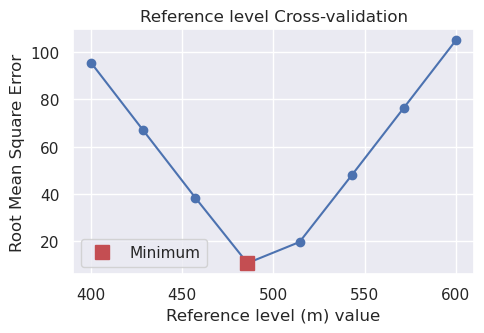

In [8]:
best_inv_results, best_zref, _, _, _, _ = (
    cross_validation.zref_density_optimal_parameter(
        grav_df=grav_df,
        constraints_df=constraint_points,
        zref_values=np.linspace(400, 600, 8),
        starting_topography_kwargs={
            "method": "flat",
            "region": region,
            "spacing": spacing,
        },
        regional_grav_kwargs={
            "regional_method": "constant",
            "constant": 0,
        },
        plot_cv=True,
        **kwargs,
    )
)

Lets see how the cross-validation perform by comparing the estimated `best` reference level value to the true value used to create the observed gravity.

In [9]:
print(f"True zref value: {true_zref}, best zref from CV: {best_zref}")

True zref value: 492.2704164812973, best zref from CV: 485.7142857142857


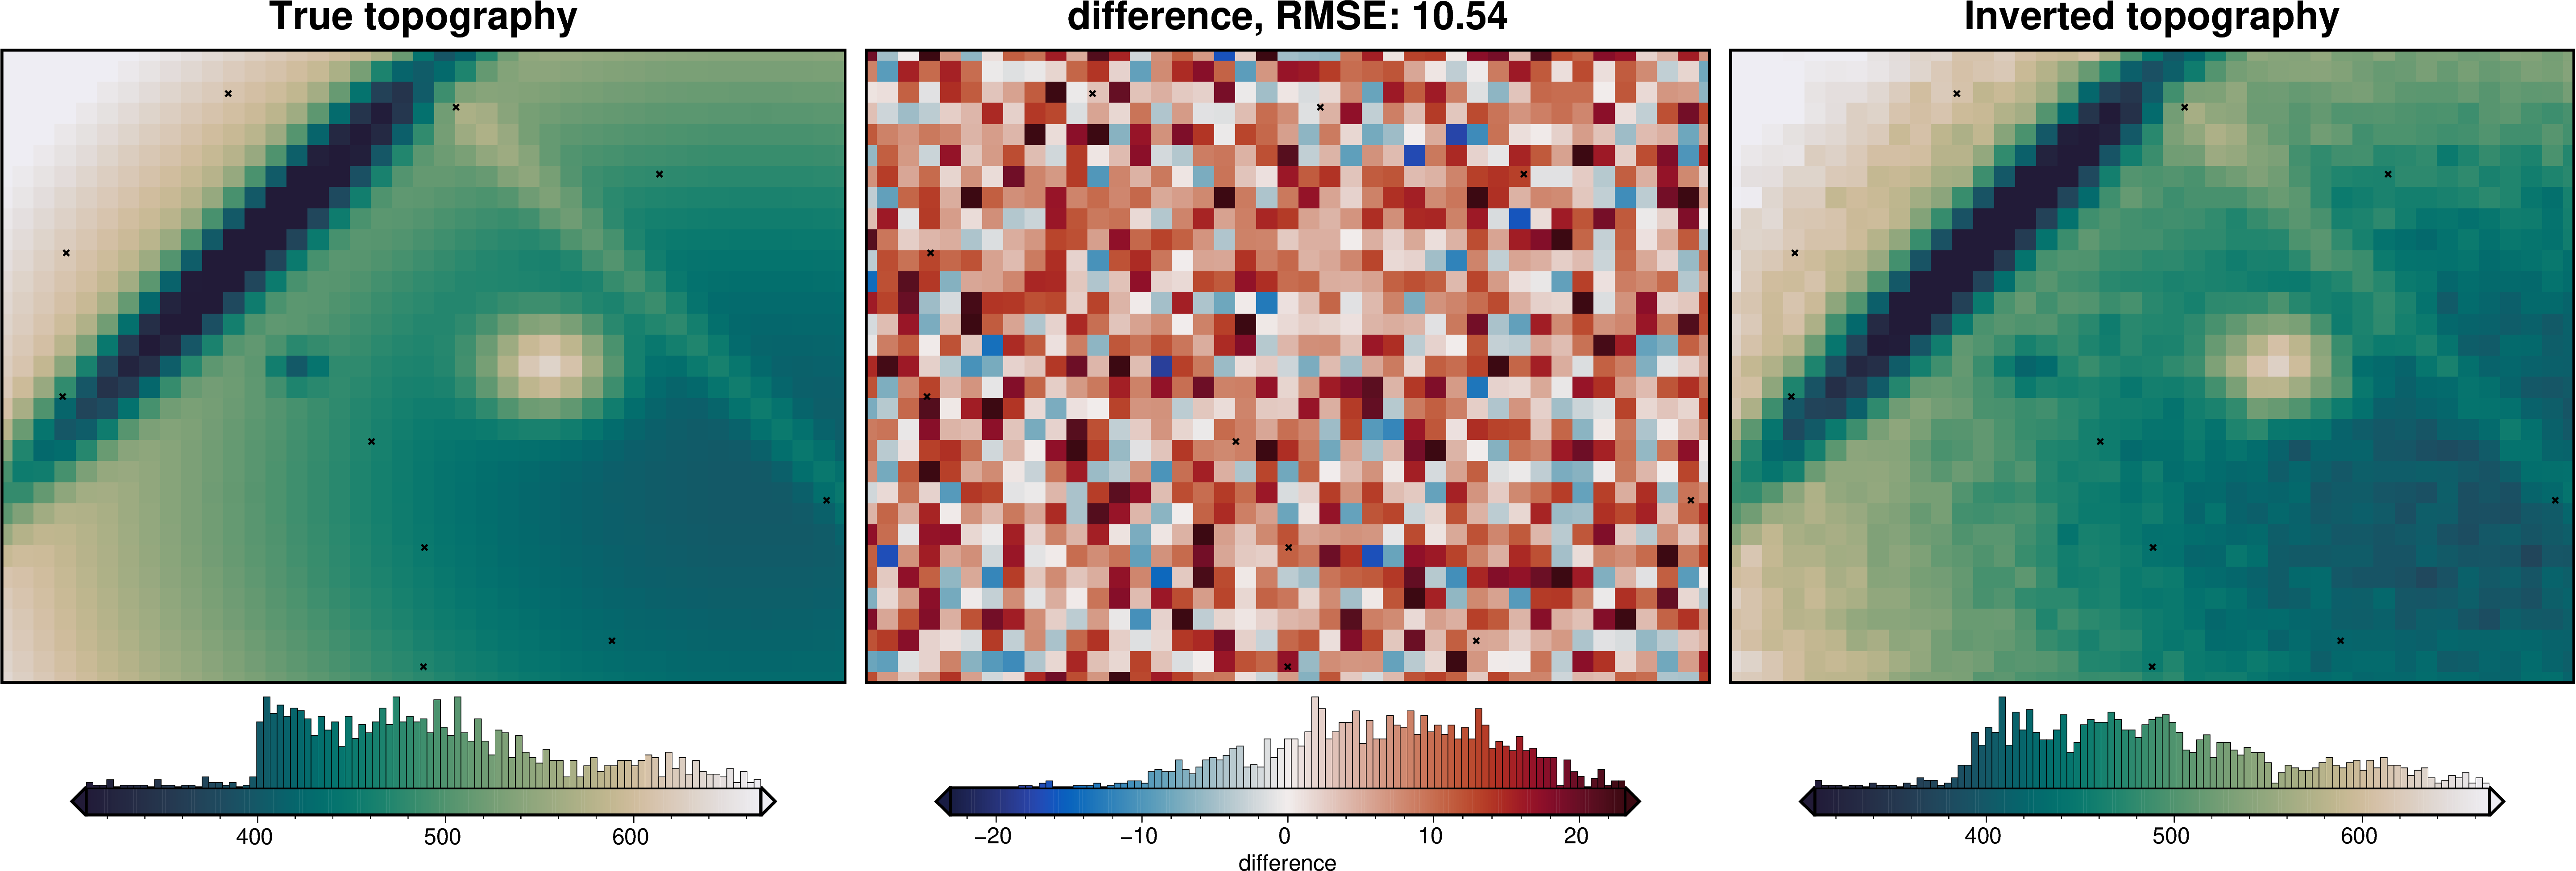

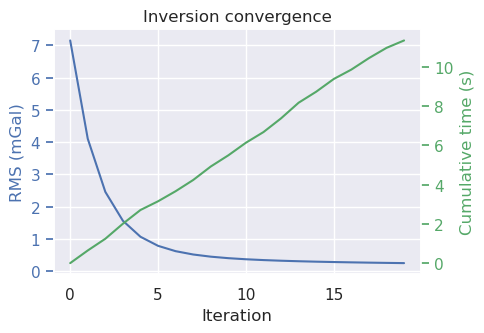

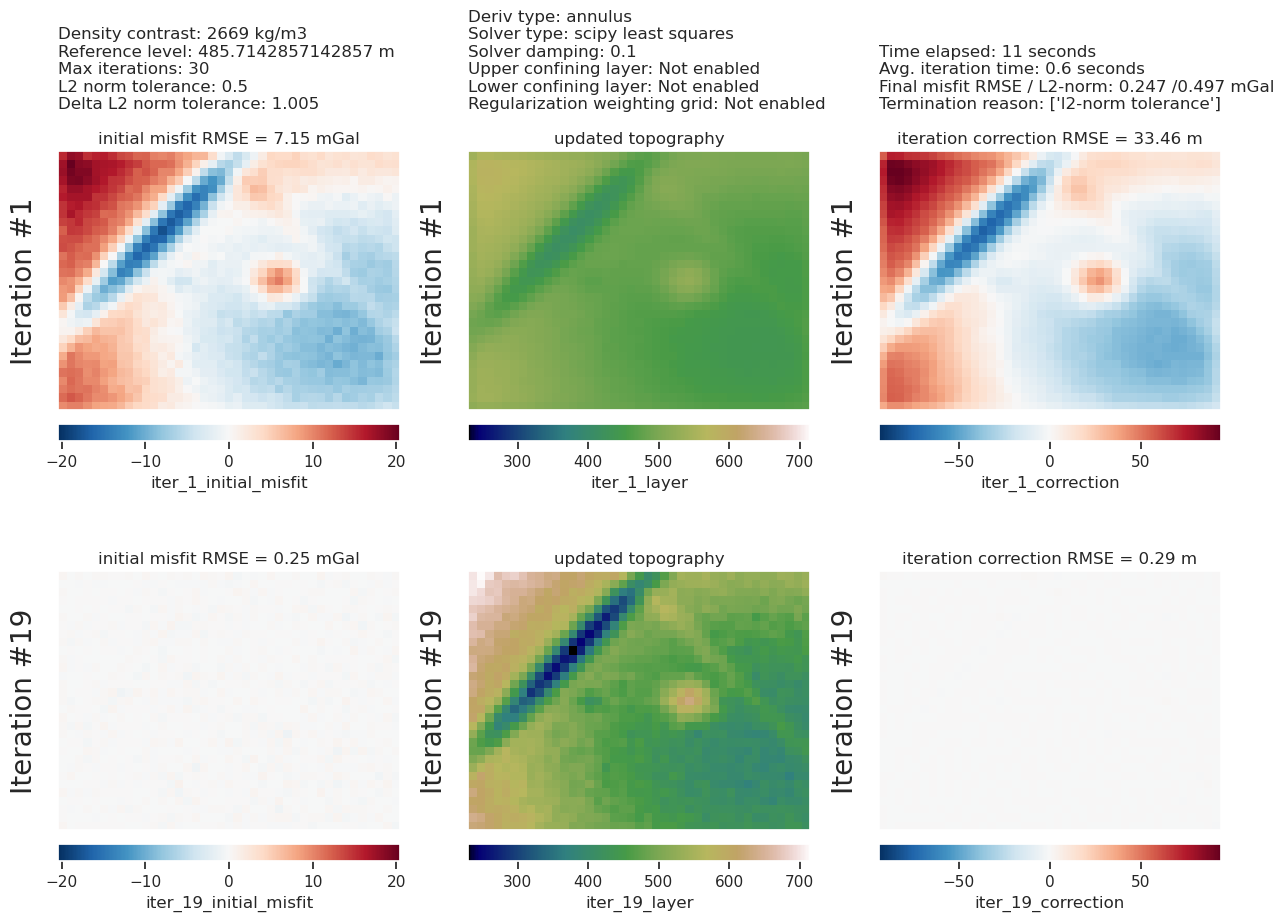

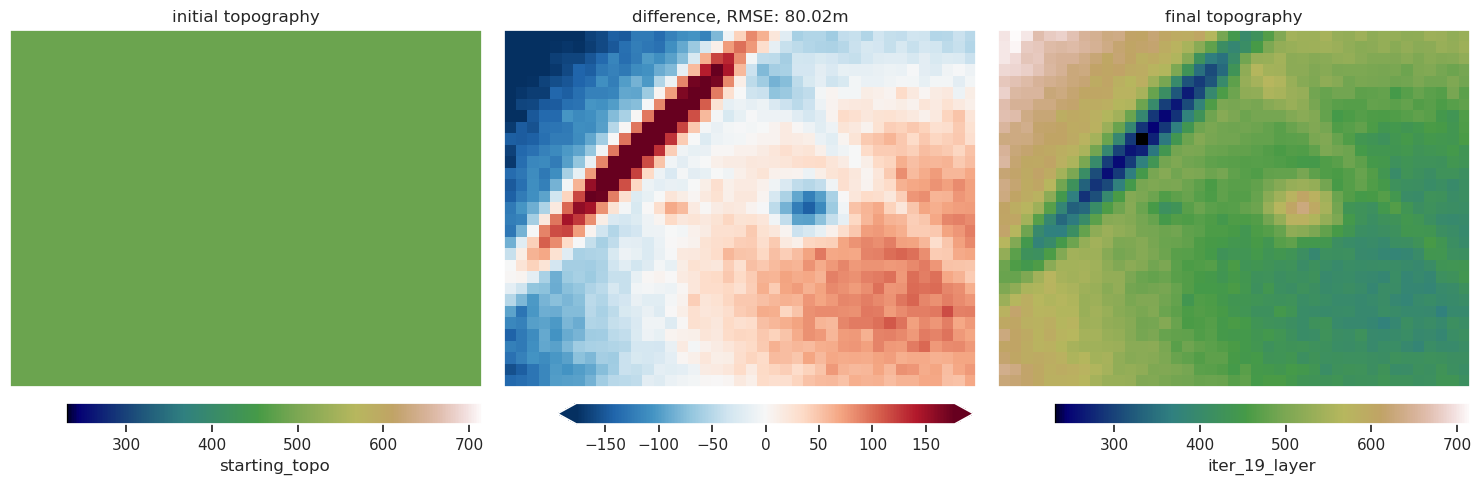

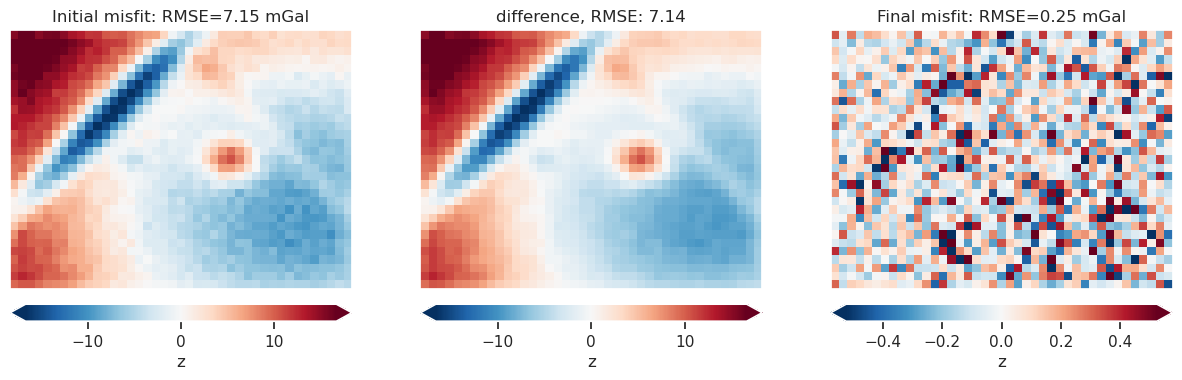

In [10]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = best_inv_results

plotting.plot_convergence(
    grav_results,
    iter_times=parameters["Iteration times"],
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

## Run inversion with poor choice of reference level

In [11]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set a bad reference level
bad_zref = 300

kwargs = {
    # inversion kwargs
    "grav_data_column": "observed_grav",
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    "deriv_type": "annulus",
    "solver_damping": 0.1,
    "zref": bad_zref,
    "density_contrast": 2669,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
    "starting_topography_kwargs": {
        "method": "flat",
        "upwards": bad_zref,
        "region": region,
        "spacing": spacing,
    },
    "regional_grav_kwargs": {
        "regional_method": "constant",
        "constant": 0,
    },
}

results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_gravity_misfit=True,
    calculate_regional_misfit=True,
    **kwargs,
)
# results
# collect the results
topo_results, grav_results, parameters, elapsed_time = results

Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

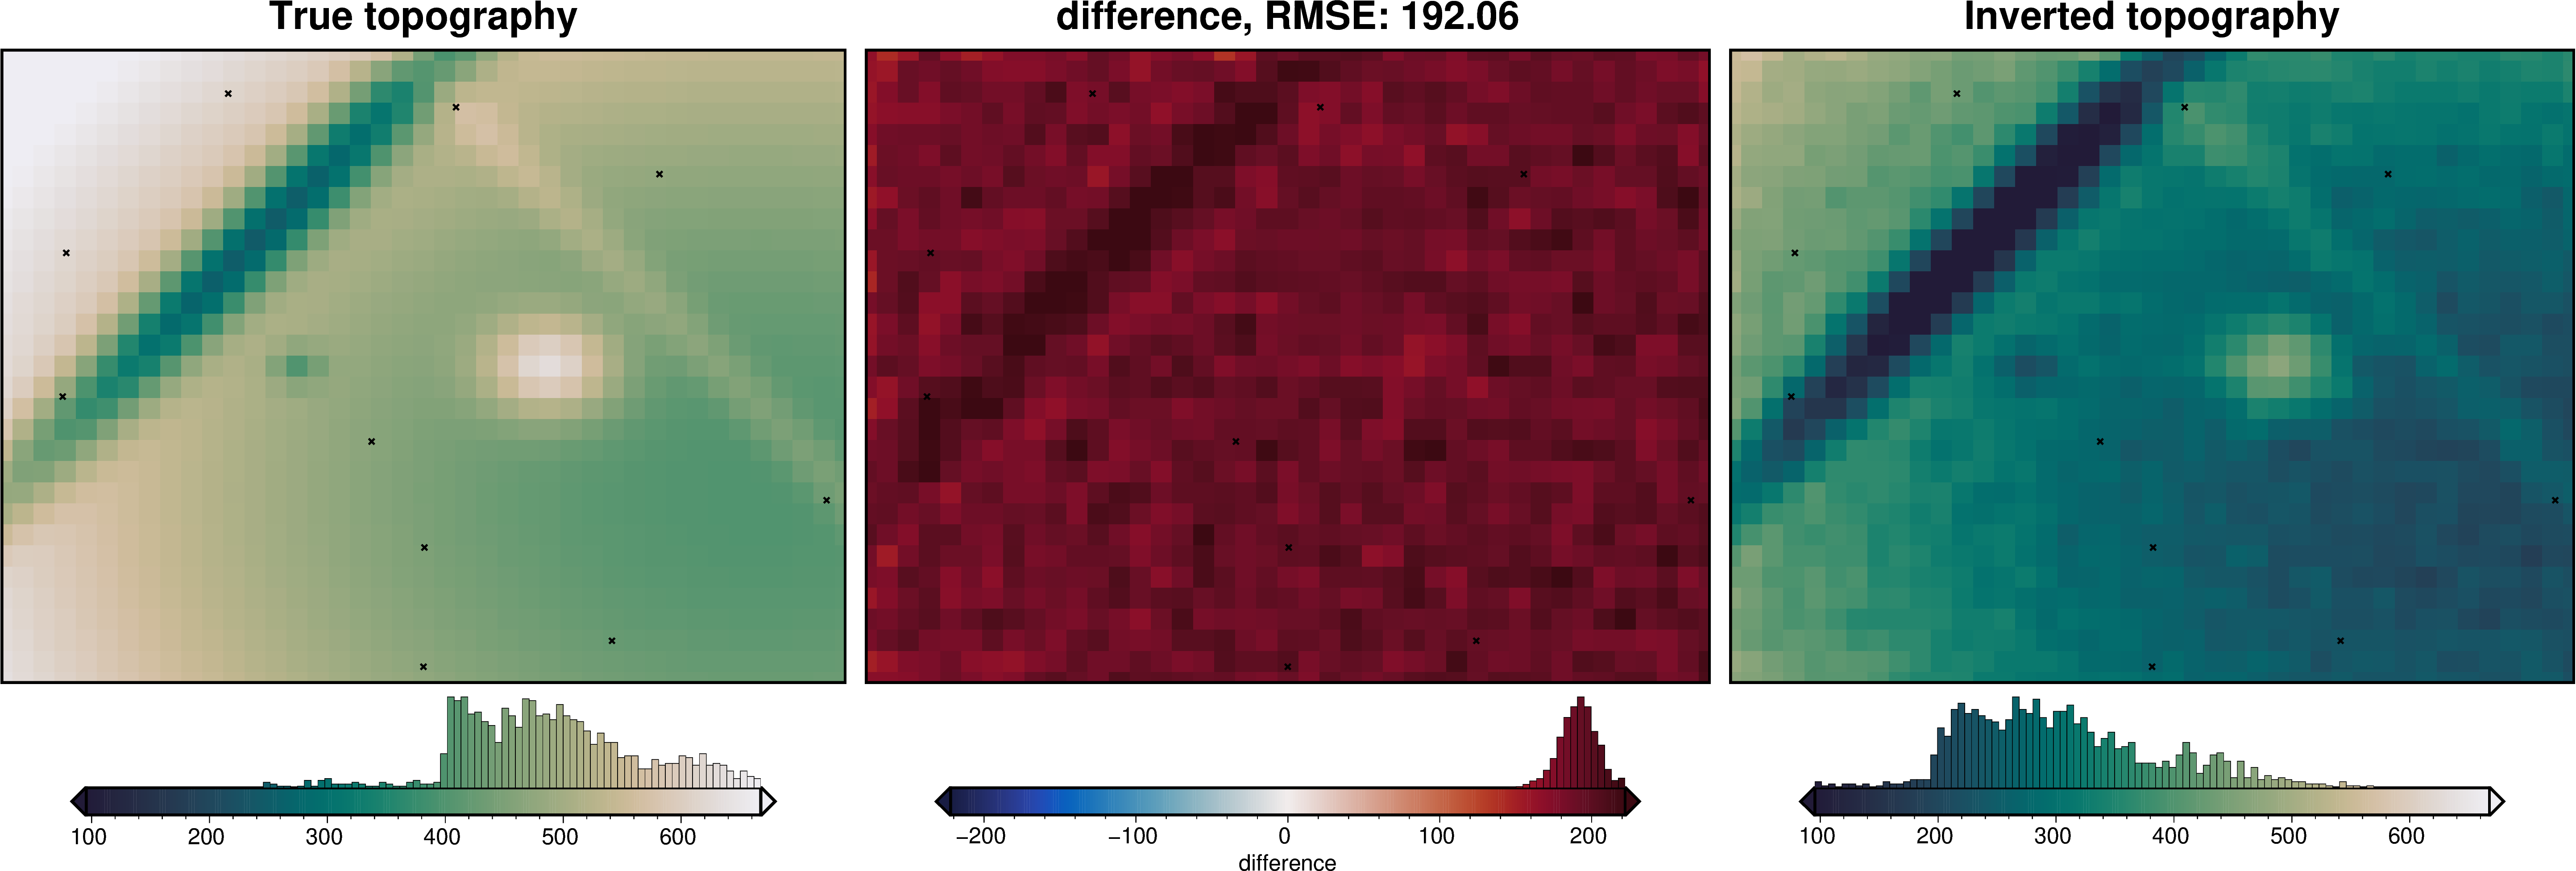

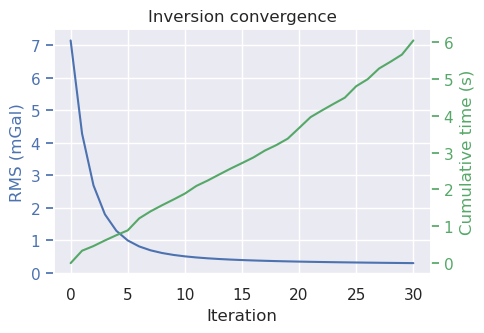

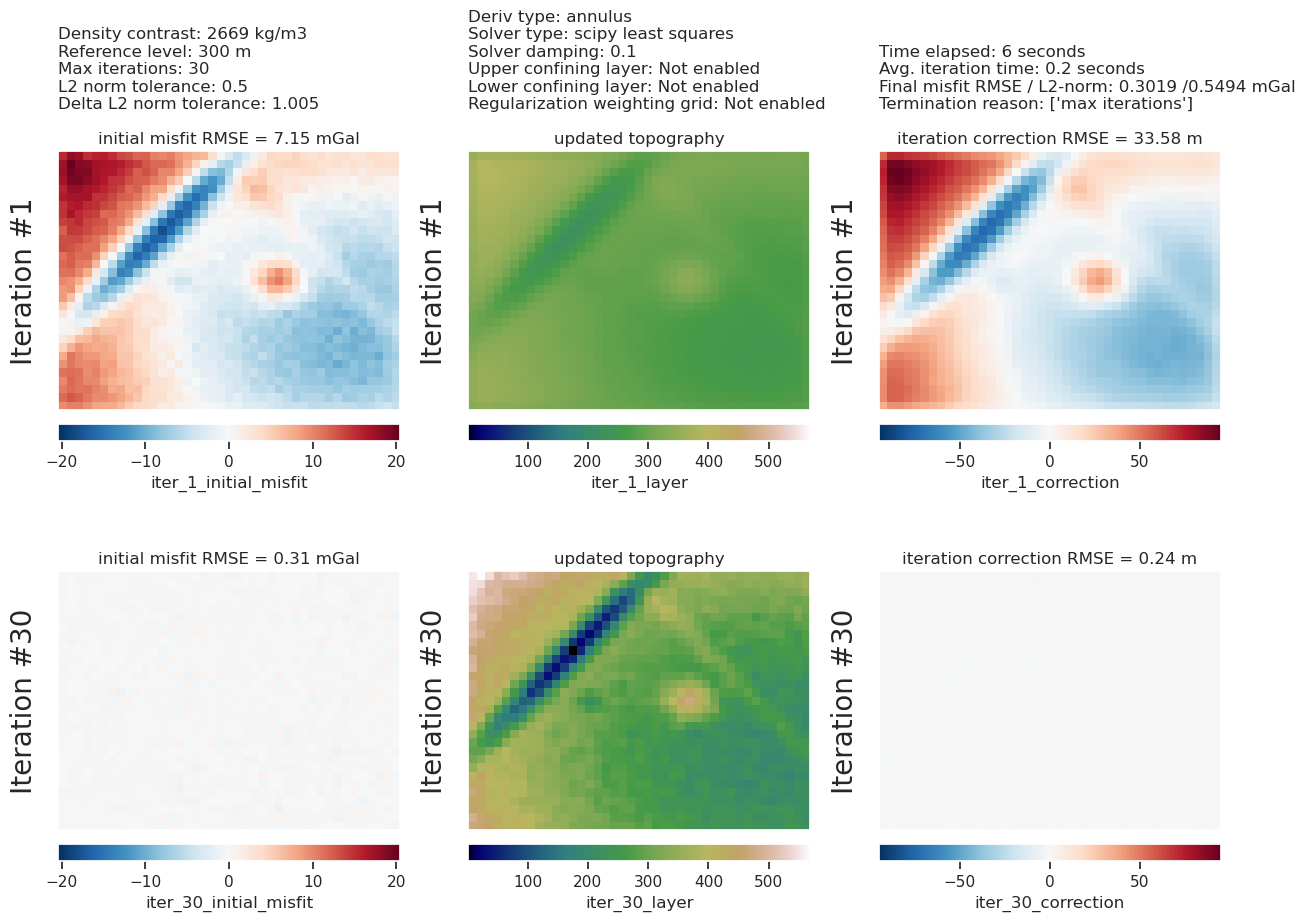

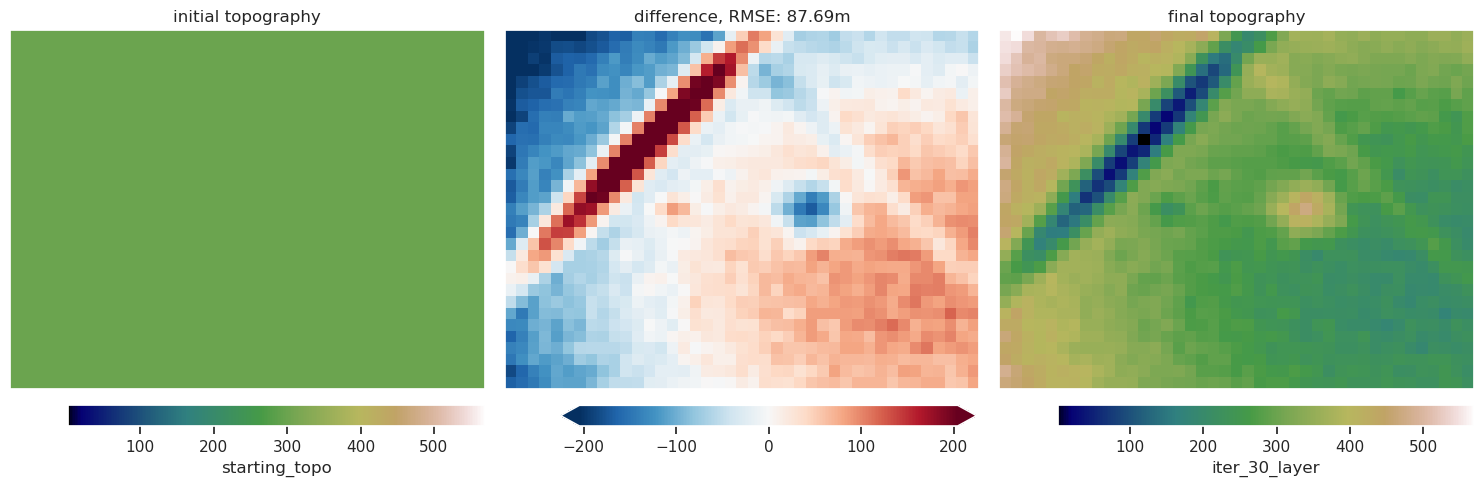

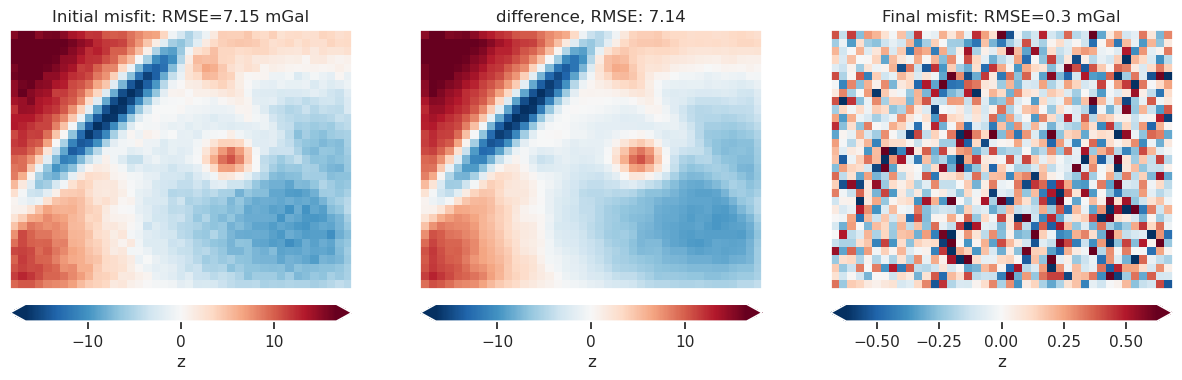

In [12]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = results

plotting.plot_convergence(
    grav_results,
    iter_times=parameters["Iteration times"],
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

This inversion with a zref of 300m  instead of the optimal zref of ~490m, shows that an incorrect zref will result in an inverted topography which vertically offset from the true topography. Estimating and removing a regional component of the gravity misfit may help this, but the zref cross validation is an effect tool to reduce these errors.